Primary kpi tracker:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import warnings
from generate_data import simulate_gps_data

df, meta = simulate_gps_data(seed=42, simulate_sampling_gaps=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['cow_id', 'timestamp']).reset_index(drop=True)

#Paddock boundaries
lat_min = meta['paddock']['lat_min']
lat_max = meta['paddock']['lat_max']
lon_min = meta['paddock']['lon_min']
lon_max = meta['paddock']['lon_max']

print(f"Loaded {len(df):,} rows of data across {df['cow_id'].nunique()} cows.")
df.head()
os.makedirs("data", exist_ok=True)
df.to_csv("../data/simulated_cow_data.csv", index=False)



Loaded 28,214 rows of data across 20 cows.


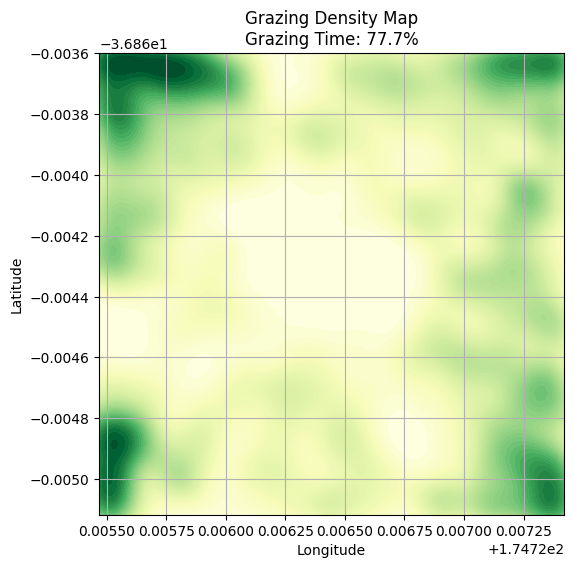

Grazing efficiency: Cows spent 77.7% of tracked time grazing.


In [2]:
#Calculate
grazing_pct = df['is_grazing'].mean() * 100

#Grazing density heatmap
plt.figure(figsize=(6, 6))
grazing_points = df[df['is_grazing']]
sns.kdeplot(
    x=grazing_points['lon'],
    y=grazing_points['lat'],
    fill=True,
    cmap="YlGn",
    bw_adjust=0.5,
    levels=50,
    thresh=0
)
plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)
plt.title(f"Grazing Density Map\nGrazing Time: {grazing_pct:.1f}%")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

print(f"Grazing efficiency: Cows spent {grazing_pct:.1f}% of tracked time grazing.")


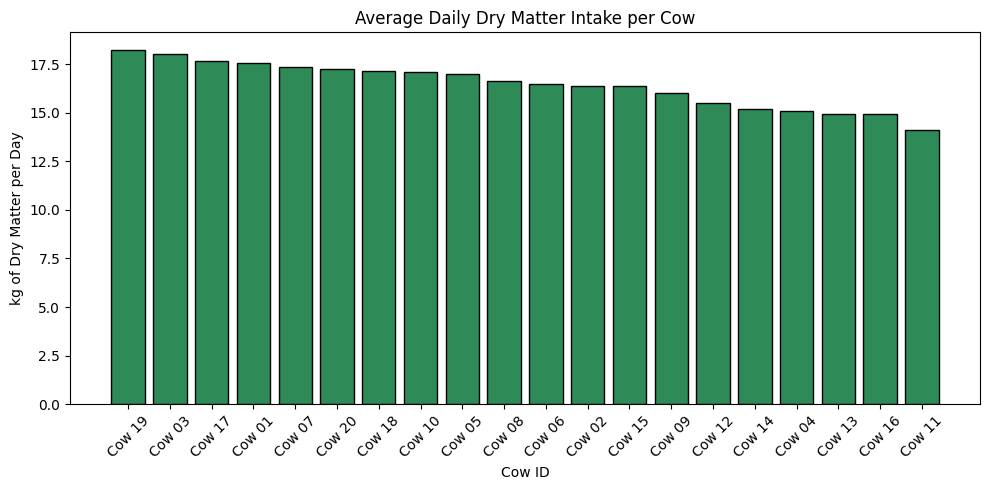

In [4]:
#define intake rate
INTAKE_RATE = 0.03
STEP_MINUTES = 1

df["date"] = df["timestamp"].dt.date

#kg/DM per cow per day
df["kg_dm"] = df["is_grazing"].astype(float) * INTAKE_RATE* STEP_MINUTES
daily_totals = df.groupby(["cow_id", "date"])["kg_dm"].sum().reset_index()

#Calculate average
avg_dm_per_cow = (
    daily_totals.groupby("cow_id")["kg_dm"]
    .mean()
    .reset_index(name="avg_kg_dm_per_day")
    .sort_values("avg_kg_dm_per_day", ascending=False)
)

#Plot
plt.figure(figsize=(10, 5))
plt.bar(avg_dm_per_cow["cow_id"], avg_dm_per_cow["avg_kg_dm_per_day"], color="seagreen", edgecolor="black")
plt.title("Average Daily Dry Matter Intake per Cow")
plt.xlabel("Cow ID")
plt.ylabel("kg of Dry Matter per Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


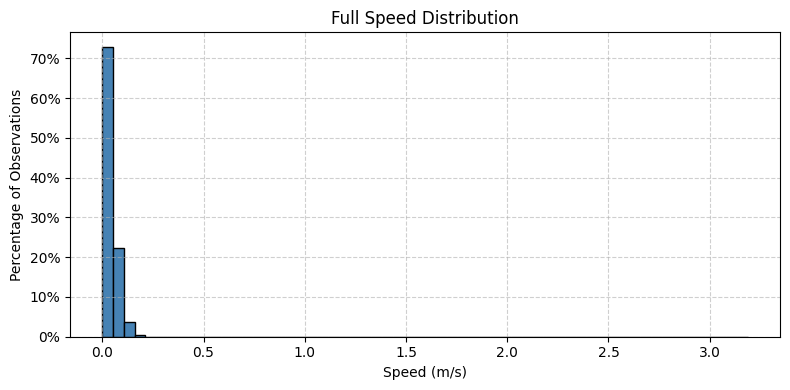

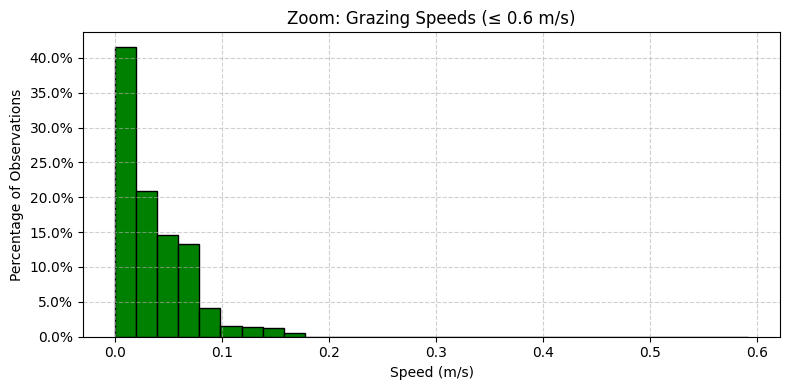

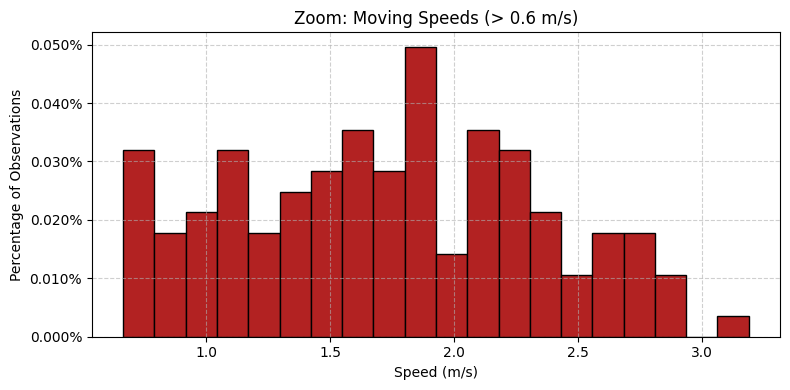

In [3]:
#Setup
full_data = df["speed_m_s"]
grazing_data = df[df["speed_m_s"] <= 0.6]["speed_m_s"]
moving_data = df[df["speed_m_s"] > 0.6]["speed_m_s"]

#Full Plot
plt.figure(figsize=(8, 4))
plt.hist(
    full_data,
    bins=60,
    weights=np.ones_like(full_data) / len(df),
    color="steelblue",
    edgecolor="black"
)
plt.title("Full Speed Distribution")
plt.xlabel("Speed (m/s)")
plt.ylabel("Percentage of Observations")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#Grazing Plot (≤ 0.1 m/s)
plt.figure(figsize=(8, 4))
plt.hist(
    grazing_data,
    bins=30,
    weights=np.ones_like(grazing_data) / len(df),
    color="green",
    edgecolor="black"
)
plt.title("Zoom: Grazing Speeds (≤ 0.6 m/s)")
plt.xlabel("Speed (m/s)")
plt.ylabel("Percentage of Observations")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#Moving Plot (> 0.6 m/s)
plt.figure(figsize=(8, 4))
plt.hist(
    moving_data,
    bins=20,
    weights=np.ones_like(moving_data) / len(df),
    color="firebrick",
    edgecolor="black"
)
plt.title("Zoom: Moving Speeds (> 0.6 m/s)")
plt.xlabel("Speed (m/s)")
plt.ylabel("Percentage of Observations")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

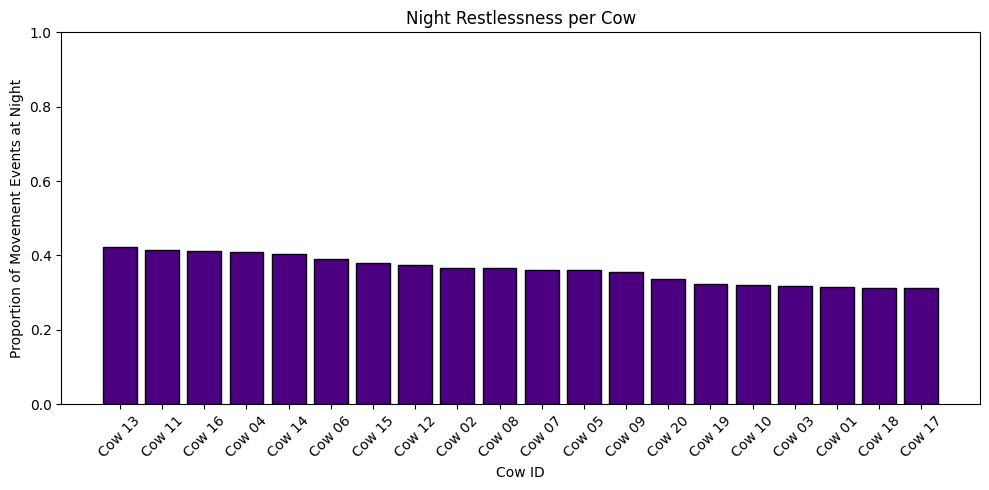

In [5]:
MOVEMENT_THRESHOLD = 0.02

df["is_moving"] = df["speed_m_s"] > MOVEMENT_THRESHOLD
df[df["is_night"]]["speed_m_s"].describe()

movement_counts = df[df["is_moving"]].groupby("cow_id")["is_night"].agg(
    total_events="count",
    night_events="sum"
).reset_index()

#Calculate
movement_counts["night_restlessness"] = (
    movement_counts["night_events"] / movement_counts["total_events"]
)

#Sort
movement_counts = movement_counts.sort_values("night_restlessness", ascending=False)

#plot
plt.figure(figsize=(10, 5))
plt.bar(movement_counts["cow_id"], movement_counts["night_restlessness"], color="indigo", edgecolor="black")
plt.title("Night Restlessness per Cow")
plt.xlabel("Cow ID")
plt.ylabel("Proportion of Movement Events at Night")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Data validation:

Cows with time sampling gaps:


,cow_id,gap_count
12,Cow 13,43
8,Cow 09,41
17,Cow 18,40
15,Cow 16,39
3,Cow 04,38
11,Cow 12,37
0,Cow 01,35
18,Cow 19,34
5,Cow 06,34
16,Cow 17,30


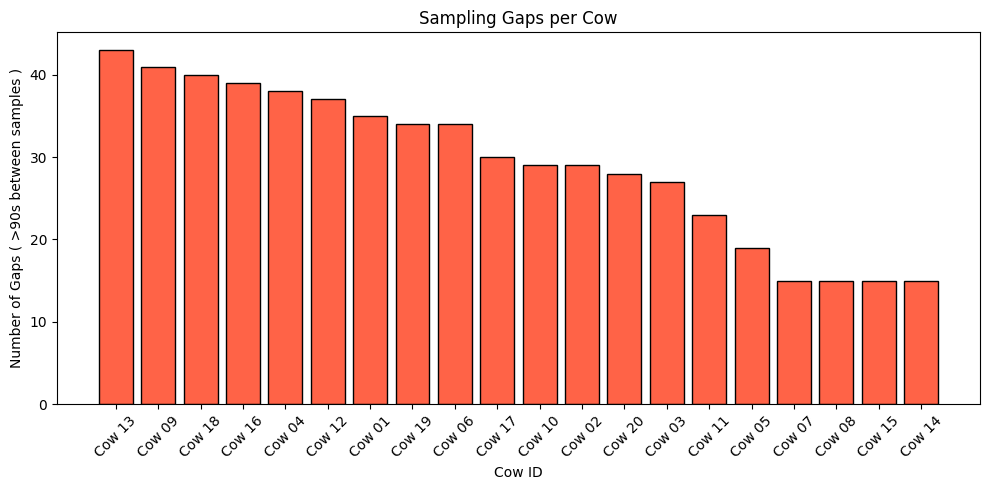

In [6]:
#values & sorting
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["cow_id", "timestamp"])

#Good data definition
EXPECTED_STEP_SEC = 60
GAP_THRESHOLD_SEC = EXPECTED_STEP_SEC * 1.5

#Calculate time gaps
df["time_diff"] = (
    df.groupby("cow_id")["timestamp"]
    .diff()
    .dt.total_seconds()
)

# Flag gaps
df["is_gap"] = df["time_diff"] > GAP_THRESHOLD_SEC

#Count gaps
gap_stats = (
    df.groupby("cow_id")["is_gap"]
    .sum()
    .reset_index(name="gap_count")
)

#Sort
gap_stats = gap_stats.sort_values("gap_count", ascending=False)

#Summary
print("Cows with time sampling gaps:")
display(gap_stats[gap_stats["gap_count"] > 0])

#Plot
plt.figure(figsize=(10, 5))
plt.bar(gap_stats["cow_id"], gap_stats["gap_count"], color="tomato", edgecolor="black")
plt.title("Sampling Gaps per Cow")
plt.xlabel("Cow ID")
plt.ylabel("Number of Gaps ( >90s between samples )")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Cows with out-of-bounds positions:


,cow_id,out_of_bounds_count


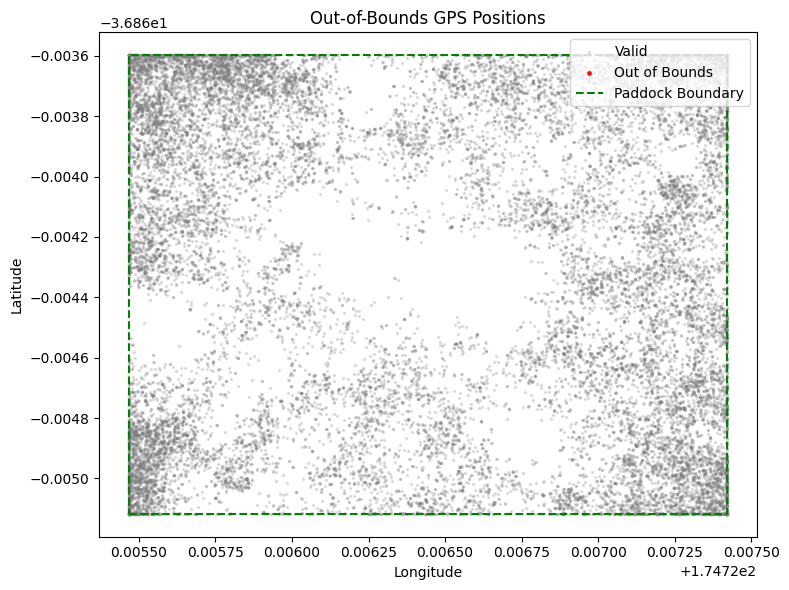

In [7]:
#Paddock bounds
lat_min = meta["paddock"]["lat_min"]
lat_max = meta["paddock"]["lat_max"]
lon_min = meta["paddock"]["lon_min"]
lon_max = meta["paddock"]["lon_max"]

#Flag out-of-bounds
df["out_of_bounds"] = (
    (df["lat"] < lat_min) | (df["lat"] > lat_max) |
    (df["lon"] < lon_min) | (df["lon"] > lon_max)
)

#Count per cow
oob_stats = (
    df.groupby("cow_id")["out_of_bounds"]
    .sum()
    .reset_index(name="out_of_bounds_count")
    .sort_values("out_of_bounds_count", ascending=False)
)

#Number of cows out of bounds
print("Cows with out-of-bounds positions:")
display(oob_stats[oob_stats["out_of_bounds_count"] > 0])

#plot
plt.figure(figsize=(8, 6))

#In paddock
plt.scatter(df[~df["out_of_bounds"]]["lon"], df[~df["out_of_bounds"]]["lat"],
            s=2, alpha=0.2, label="Valid", color="grey")

#Out of paddock
plt.scatter(df[df["out_of_bounds"]]["lon"], df[df["out_of_bounds"]]["lat"],
            s=6, alpha=0.9, label="Out of Bounds", color="red")

#Paddock box around graph
plt.plot(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    linestyle="--", color="green", label="Paddock Boundary"
)

plt.title("Out-of-Bounds GPS Positions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


Cows with biologically implausible speed spikes (> 3.0 m/s):


,cow_id,spike_count
8,Cow 09,1


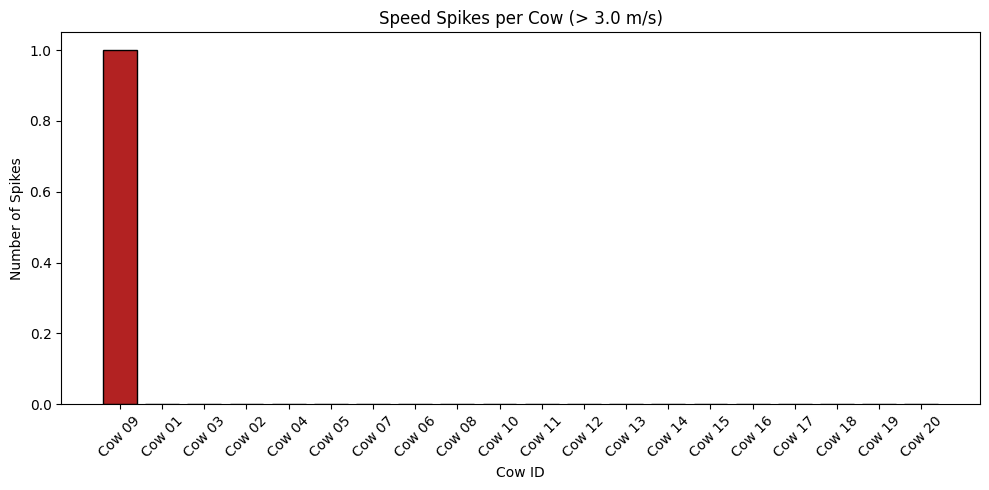

In [8]:
#flag spikes
SPEED_SPIKE_THRESHOLD = 3.0  # m/s
df["is_speed_spike"] = df["speed_m_s"] > SPEED_SPIKE_THRESHOLD

#count spikes per cow 
spike_counts = (
    df.groupby("cow_id")["is_speed_spike"]
    .sum()
    .reset_index(name="spike_count")
    .sort_values("spike_count", ascending=False)
)

#Cows with a spike
print("Cows with biologically implausible speed spikes (> 3.0 m/s):")
display(spike_counts[spike_counts["spike_count"] > 0])

plt.figure(figsize=(10, 5))
plt.bar(spike_counts["cow_id"], spike_counts["spike_count"], color="firebrick", edgecolor="black")
plt.title("Speed Spikes per Cow (> 3.0 m/s)")
plt.xlabel("Cow ID")
plt.ylabel("Number of Spikes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

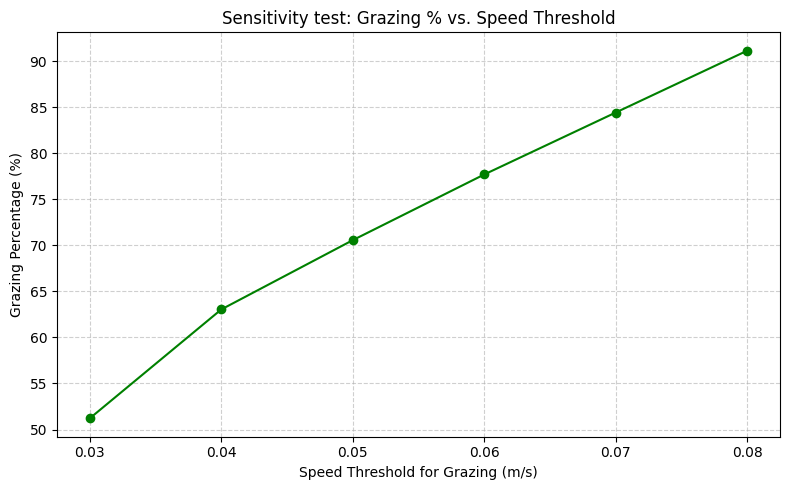

In [9]:
#grazing speeds to simulate
thresholds = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

grazing_sensitivity = []
for t in thresholds:
    grazing_flag = df["speed_m_s"] <= t
    grazing_pct = grazing_flag.mean() * 100
    grazing_sensitivity.append({"threshold": t, "grazing_pct": grazing_pct})

#convert to DataFrame for plotting
grazing_sensitivity_df = pd.DataFrame(grazing_sensitivity)

#plot
plt.figure(figsize=(8, 5))
plt.plot(
    grazing_sensitivity_df["threshold"],
    grazing_sensitivity_df["grazing_pct"],
    marker="o", color="green"
)
plt.title("Sensitivity test: Grazing % vs. Speed Threshold")
plt.xlabel("Speed Threshold for Grazing (m/s)")
plt.ylabel("Grazing Percentage (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


SQL:

In [10]:
import duckdb

#Load CSV
duckdb.sql("""
    CREATE VIEW cow_tracking AS 
    SELECT * FROM '../data/simulated_cow_data.csv'
""")

#Grazing efficiency
df_kpi = duckdb.sql("""
    SELECT 
        cow_id,
        DATE(timestamp) AS date,
        COUNT(*) AS total_rows,
        COUNT(*) FILTER (WHERE is_grazing) AS grazing_rows,
        ROUND(100.0 * COUNT(*) FILTER (WHERE is_grazing) / COUNT(*), 2) AS grazing_percent
    FROM cow_tracking
    GROUP BY cow_id, DATE(timestamp)
""").df()

df_kpi.head()

,cow_id,date,total_rows,grazing_rows,grazing_percent
0,Cow 02,2025-01-01,1062,825,77.68
1,Cow 11,2025-01-02,351,212,60.40
2,Cow 16,2025-01-02,347,208,59.94
3,Cow 19,2025-01-02,348,333,95.69
4,Cow 07,2025-01-01,1072,868,80.97
